Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Setup and load data

#### Importing all the important libraries

##### Install all required libraries

In [2]:
#%pip install scipy

In [3]:
#%pip install tensorflow-metal

In [4]:
#%pip install tensorflow-gpu

In [5]:
#%pip install matplotlib

In [6]:
#%pip install pandas

#### Verify if GPU is available

In [7]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [8]:
import tensorflow as tf
print(tf.__version__)

2.16.2


#### Import all required libraries

In [76]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob

from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")


In [10]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('../data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [12]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create Accuracy dataframe to capture performance data of various models

In [79]:
# Initialize an empty DataFrame
accuracy_df = pd.DataFrame(columns=["Model", "Training Accuracy", "Validation Accuracy"])

# Helper function to insert model performance
def insert_performance(model_name, train_acc, val_acc):
    global accuracy_df
    accuracy_df.loc[len(accuracy_df)] = [model_name, train_acc, val_acc]


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-07-10 11:17:22.052322: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-10 11:17:22.052358: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-10 11:17:22.052369: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-10 11:17:22.052393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 11:17:22.052425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

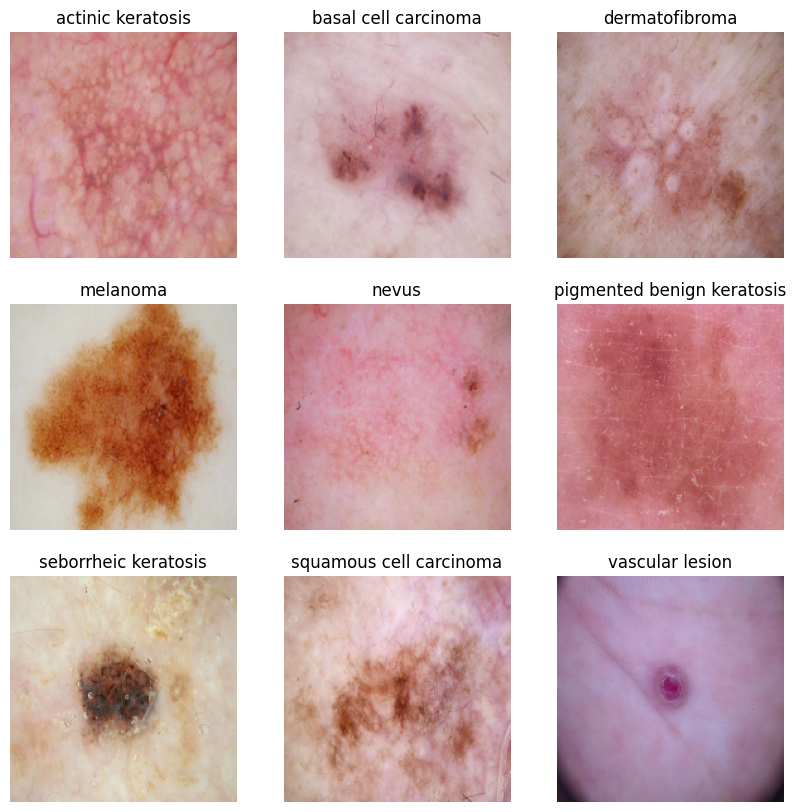

In [17]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Dictionary to store one image per class
class_images = {class_name: None for class_name in class_names}

# Iterate through the dataset to find one image per class
for images, labels in train_ds:
    for i in range(images.shape[0]):
        label = labels[i].numpy()
        class_name = class_names[label]
        if class_images[class_name] is None:
            class_images[class_name] = images[i].numpy()
        # Break if all classes have been found
        if all(img is not None for img in class_images.values()):
            break
    if all(img is not None for img in class_images.values()):
        break

# Plotting the images
plt.figure(figsize=(10, 10))
for idx, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(3, 3, idx + 1)
    plt.title(class_name)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We will use the following order to train our model:
Convolution → BatchNormalization → Activation (e.g., ReLU) → Pooling

Following are the advantages of doing batch normalization before calling activation function:
- **Improved Training Stability**: Normalizing the output of the convolutional layer before activation can help stabilize the training process.
- **Accelerated Convergence**: It often helps in faster convergence during training.
- **Mitigates Internal Covariate Shift**: By normalizing before applying the non-linearity, it reduces the issue of internal covariate shift more effectively.
- **Mean and Variance Impact**: BN adjusts the mean and variance of the convolutional layer's output, ensuring that the inputs to the activation function have a stable distribution

Standard architectures like Resnet and Inception follow this practice. However, specific use cases and datasets might benefit from experimenting with different placements. 

I will experiment based on the above method illustrated.

In [19]:
### Your code goes here
# Create the CNN model
model = models.Sequential([
    # Input layer to define the input shape
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps before the fully connected layer
    layers.Flatten(),

    # Fully connected layer with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

Batch normalization can be applied to convolutional layers and is typically inserted after the convolution operation but before the activation function. 
A typical convolutional block with batch normalization looks:
- Convolution Layer
- Batch Normalization
- Activation Function (e.g., ReLU)
- Pooling Layer (MaxPooling in above case)
- configure dropouts

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-07-10 11:17:23.853963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.2491 - loss: 7.2147 - val_accuracy: 0.2036 - val_loss: 2.1395
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3795 - loss: 1.7155 - val_accuracy: 0.1499 - val_loss: 2.3072
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4558 - loss: 1.5283 - val_accuracy: 0.1499 - val_loss: 2.3593
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4550 - loss: 1.5402 - val_accuracy: 0.1499 - val_loss: 2.3821
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4614 - loss: 1.5067 - val_accuracy: 0.1499 - val_loss: 2.6445
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4793 - loss: 1.4429 - val_accuracy: 0.2394 - val_loss: 2.2150
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4768 - loss: 1.4133 - val_accuracy: 0.2013 - val_loss: 2.2221
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5308 - loss: 1.3481 - val_accuracy: 0.3490 - val_los

### Visualizing training results

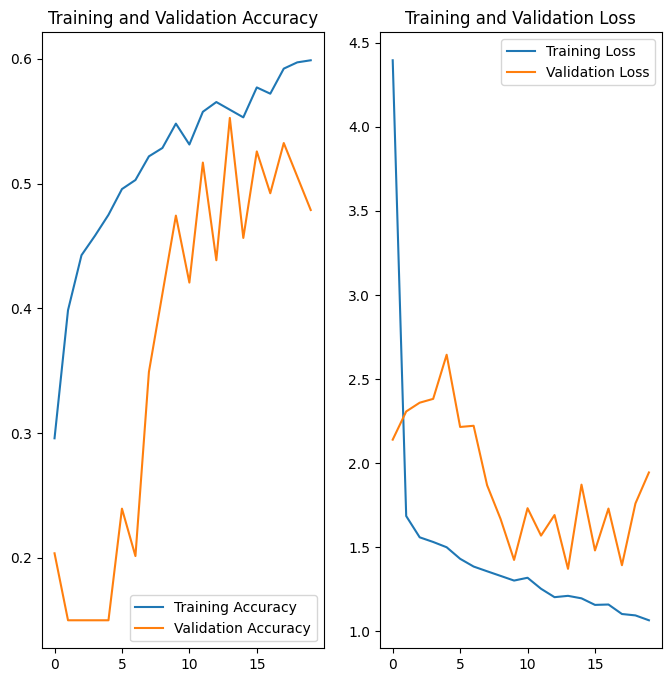

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
for i in range(len(acc)):
  print(f"Training accuracy: {history.history['accuracy'][i] * 100:.2f}%, validation accuracy: {history.history['val_accuracy'][i] * 100:.2f}%")    

Training accuracy: 29.58%, validation accuracy: 20.36%
Training accuracy: 39.84%, validation accuracy: 14.99%
Training accuracy: 44.25%, validation accuracy: 14.99%
Training accuracy: 45.81%, validation accuracy: 14.99%
Training accuracy: 47.49%, validation accuracy: 14.99%
Training accuracy: 49.55%, validation accuracy: 23.94%
Training accuracy: 50.28%, validation accuracy: 20.13%
Training accuracy: 52.18%, validation accuracy: 34.90%
Training accuracy: 52.85%, validation accuracy: 41.16%
Training accuracy: 54.80%, validation accuracy: 47.43%
Training accuracy: 53.12%, validation accuracy: 42.06%
Training accuracy: 55.75%, validation accuracy: 51.68%
Training accuracy: 56.53%, validation accuracy: 43.85%
Training accuracy: 55.92%, validation accuracy: 55.26%
Training accuracy: 55.30%, validation accuracy: 45.64%
Training accuracy: 57.70%, validation accuracy: 52.57%
Training accuracy: 57.20%, validation accuracy: 49.22%
Training accuracy: 59.21%, validation accuracy: 53.24%
Training a

#### Evaluating Model overfit or underfit

In [25]:
# Evaluate the model on the training and validation datasets
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)

# Print the final accuracy scores
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Check for overfitting or underfitting
if train_acc > val_acc and (train_acc - val_acc) > 0.05:
    print("The model is likely overfitting.")
elif val_acc > train_acc and (val_acc - train_acc) > 0.05:
    print("The model is likely underfitting.")
else:
    print("The model is performing well with no major overfitting or underfitting.")


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5342 - loss: 1.4791
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5167 - loss: 1.9661
Final Training Accuracy: 54.80%
Final Validation Accuracy: 47.87%
The model is likely overfitting.


In [80]:
insert_performance("Initial Model", 54.80, 47.97)

We can see that with very high Training accuracy and Validation accuracy being less than threshold, we can believe that the model is very likely overfitting.

### Inference

Thus we can clearly see that model is likely Overfitting and we need to chose right data augumentation strategy, we will use ImageDataGenerator

In [26]:
# Define the augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=10, #Randomly rotates images within the specified range of degrees.
    zoom_range=0.1, #Randomly zooms inside images.
    width_shift_range=0.1, #Randomly shifts images horizontally by a fraction of the total width.
    height_shift_range=0.1, #Randomly shifts images vertically by a fraction of the total height.
    horizontal_flip=True, #Randomly flips images horizontally.
    vertical_flip=False, #Randomly flips images vertically.
    #shear_range=0.2, #Shear angle in counter-clockwise direction in degrees.
    fill_mode='nearest', #see below details
    brightness_range=(0.8, 1.2), #Randomly changes the brightness of the images.
)
# The fill_mode='nearest' parameter in Keras' ImageDataGenerator specifies how to fill in new pixels that are created when an image is transformed (e.g., rotated or shifted). 
# It fills these pixels with the nearest pixel values from the original image, effectively extending the edges of the image to handle the transformation.

# Create a generator for training data
train_batches = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

valid_batches = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


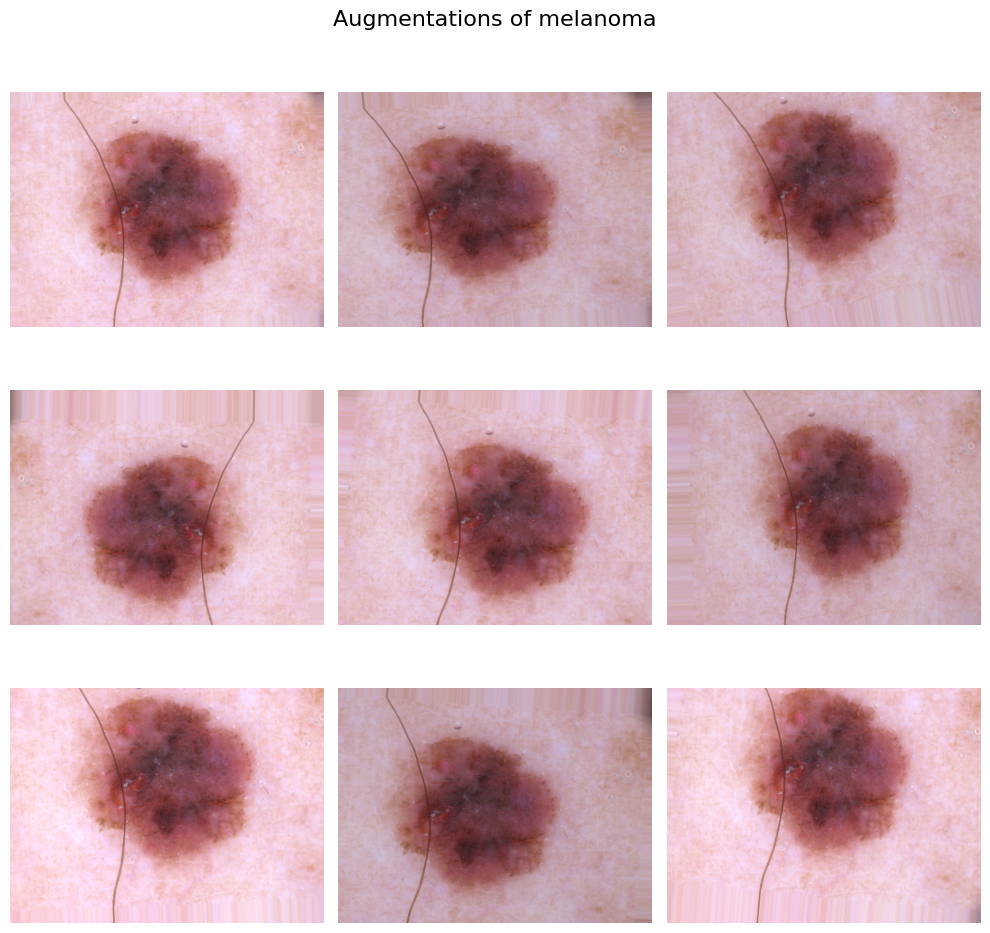

In [27]:
# Visualize the augmentation strategy for one instance of a training image
def visualize_augmentations(image_path, datagen, num_examples=9):
    img = load_img(image_path)  # Load the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape required by ImageDataGenerator
    
    # Generate augmented images
    augmented_images = [datagen.flow(img_array, batch_size=1)[0][0].astype('uint8') for _ in range(num_examples)]
    
    # Plot the augmented images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(augmented_images, axes):
        ax.imshow(img)
        ax.axis('off')
    # Set the title with the directory name
    directory_name = os.path.basename(os.path.dirname(image_path))
    fig.suptitle(f'Augmentations of {directory_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Select a sample image from the training directory for visualization
sample_image_path = os.path.join(data_dir_train, 'melanoma', 'ISIC_0000139.jpg')
visualize_augmentations(sample_image_path, datagen)

### Model 2:
### Create the model, compile and train the model


In [28]:
# Create the CNN model
model = models.Sequential([
    # Input layer to define the input shape
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    
    # Add dropout layer
    #layers.Dropout(0.20),
    
    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps before the fully connected layer
    layers.Flatten(),

    # Fully connected layer with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

### Compiling the model

In [29]:
## Your code goes here
# Compile the model

# Define the Adam optimizer with specified parameters
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



### Training the model

The lr_schedule function reduces the learning rate by a factor of exp(-0.1) after 10 epochs.
ReduceLROnPlateau is a mthod for adjusting the learning rate during training. It reduces the learning rate when a metric has stopped improving, which can be very effective for training stability and convergence, especially when the model is struggling to improve.

This method is often more dynamic and responsive to the training process compared to a fixed schedule.

In [30]:
## Your code goes here, note: train your model for 20 epochs

# Learning rate reduction on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
#EarlyStopping: Added to stop training when the model stops improving on the validation data.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_batches,
    epochs=epochs,
    verbose = 1,
    validation_data=valid_batches,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.2412 - loss: 6.1061 - val_accuracy: 0.1356 - val_loss: 2.2206 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step - accuracy: 0.3427 - loss: 1.7703 - val_accuracy: 0.1356 - val_loss: 2.2040 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 511ms/step - accuracy: 0.3883 - loss: 1.7071 - val_accuracy: 0.1356 - val_loss: 2.4065 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 534ms/step - accuracy: 0.4259 - loss: 1.5781 - val_accuracy: 0.1441 - val_loss: 2.2058 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.4479 - loss: 1.5707 - val_accuracy: 0.1356 - val_loss: 2.3250 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 526ms/step - accuracy: 0.4632 - loss: 1.5007 - val_accuracy: 0.1356 - val_loss: 2.3493 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4872 - loss: 1.4

### Visualizing the results

No. of epochs trained: 20


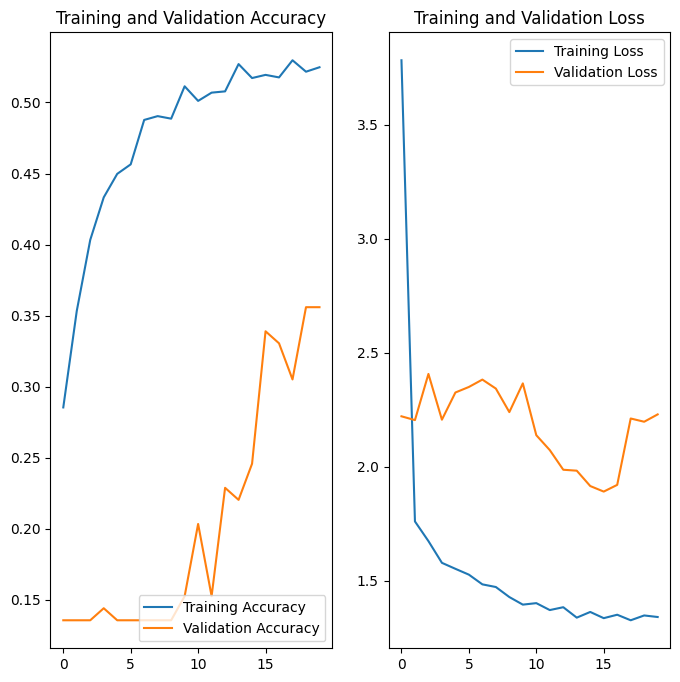

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we added early stop, we now need to determine the actual number of epochs the model trained for
print(f"No. of epochs trained: {len(acc)}")
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# Evaluate the model on the training and validation datasets
train_loss, train_acc = model.evaluate(train_batches)
val_loss, val_acc = model.evaluate(valid_batches)

# Print the final accuracy scores
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Check for overfitting or underfitting
if train_acc > val_acc and (train_acc - val_acc) > 0.05:
    print("The model is likely overfitting.")
elif val_acc > train_acc and (val_acc - train_acc) > 0.05:
    print("The model is likely underfitting.")
else:
    print("The model is performing well with no major overfitting or underfitting.")

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 470ms/step - accuracy: 0.5302 - loss: 1.2510
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3727 - loss: 2.1000
Final Training Accuracy: 54.49%
Final Validation Accuracy: 35.59%
The model is likely overfitting.


In [81]:
insert_performance("Augmented model with dropout", 54.49, 35.59)

####  Model analysis

I did several optimizations listed below:
- Data Augmentation: After running several times, I reviewed and potentially reduced the intensity of augmentations. Excessive augmentation can also make the learning task harder.
- Add Regularization
    - Dropout: Add dropout layers to prevent overfitting.
    - Weight Decay: Apply L2 regularization to the weights.
    - Batch Normalization: Normalize activations to stabilize learning
- Early Stopping to halt training when validation performance stops improving.

Training Accuracy Improvement:

* Before : 47%
* After several optimizations : 54%

This indicates that the model has learned to better fit the training data, which is a positive sign.

Validation Accuracy Drop:

* Before Augmentation: 43%
* After Augmentation: 35%

The slight drop in validation accuracy suggests that the model is overfitting, as it performs well on the training data but poorly on the validation dat

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

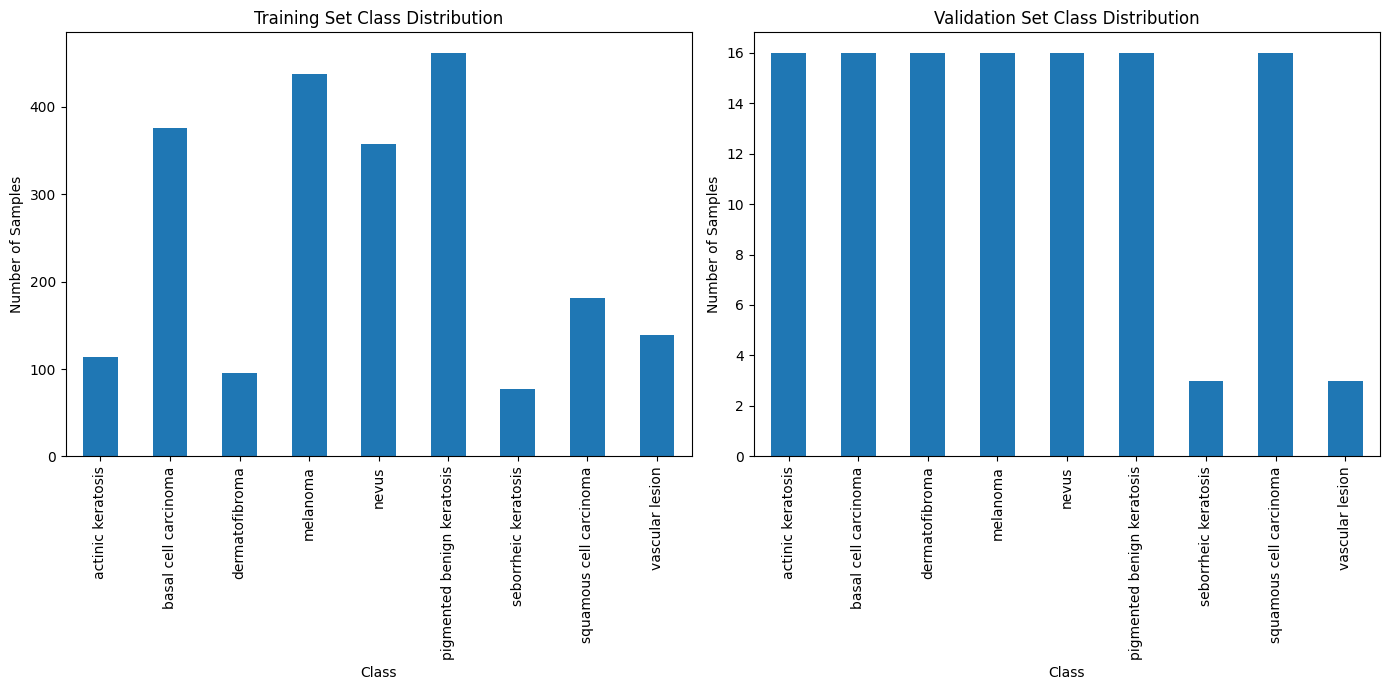

In [33]:
# Lets first look at the previous model's dataset classes and take note of any class imbalance
# Get class indices and counts
train_labels = train_batches.classes
train_class_indices = train_batches.class_indices
train_class_counts = pd.Series(train_labels).value_counts().sort_index()

test_labels = valid_batches.classes
test_class_counts = pd.Series(test_labels).value_counts().sort_index()

# Map indices to class names
class_names = {v: k for k, v in train_class_indices.items()}
train_class_counts.index = train_class_counts.index.map(class_names)
test_class_counts.index = test_class_counts.index.map(class_names)

# Plot class distributions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Training set class distribution
train_class_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')

# Validation set class distribution
test_class_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

From Data Augmentation classes, we can clearly see there is class imbalance in the generated training dataset.

Lets look at the input dataset generated from physical directories

2024-07-10 11:27:15.660655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


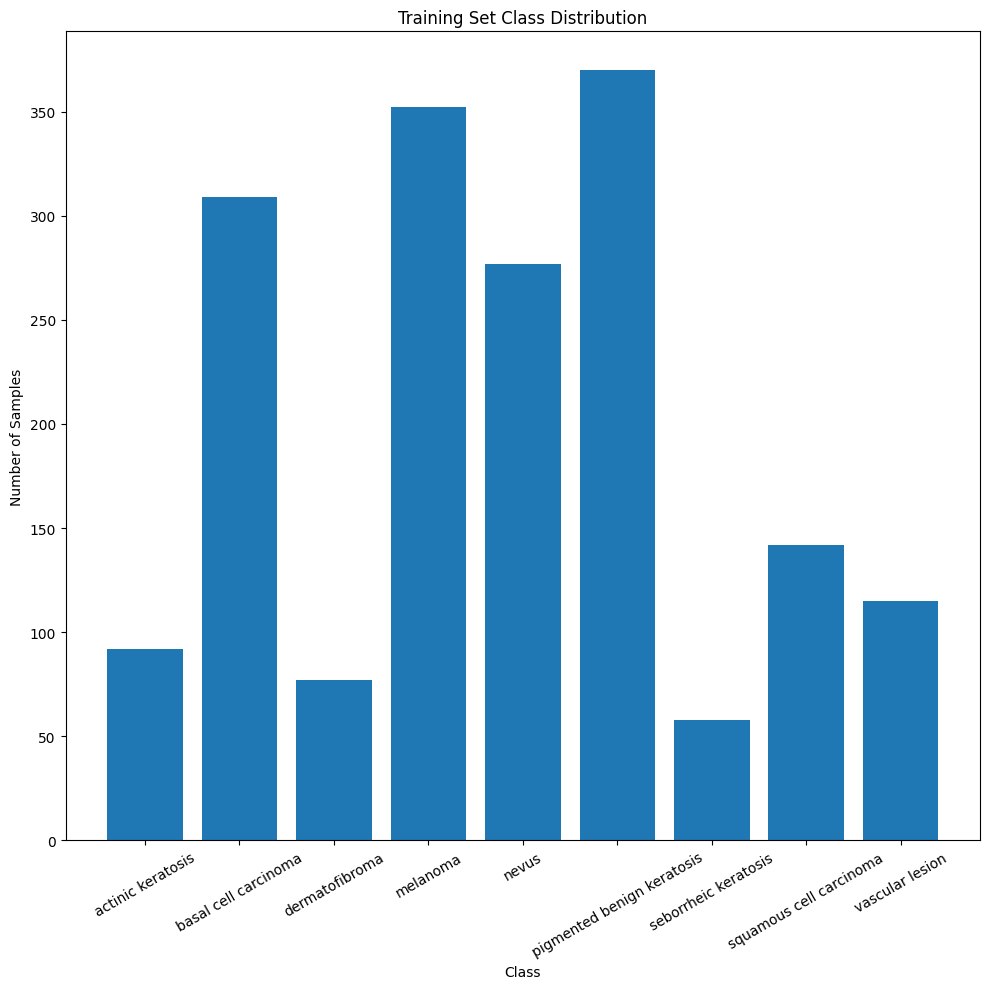

In [34]:
from collections import Counter
# Count the number of samples per class
class_counts = Counter()
for _, labels in train_ds:
    class_counts.update(labels.numpy())

# Sort the class counts by class index
sorted_class_counts = dict(sorted(class_counts.items()))

# Map class indices to class names
class_names_dict = {i: class_names[i] for i in sorted_class_counts.keys()}
sorted_class_counts = {class_names_dict[k]: v for k, v in sorted_class_counts.items()}

# Plot class distributions
plt.figure(figsize=(10, 10))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### Clearly, We need to rectify the class imbalance in both the training and validation dataset
#### - Which class has the least number of samples?

In the training dataset (top 3):

    - seborrheic keratosis, 
    - dermatofibroma,
    - vascular lesion

#### - Which classes dominate the data in terms proportionate number of samples?

The following classes dominate the dataset (top 3):

    - Pigmented benign keratosis
    - Melanoma
    - basal cell carcinoma


#### **Rectify the class imbalance**
#### **Context:** Let's use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
#%pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
print(data_dir_train)

../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [50]:
import Augmentor
from pathlib import Path

print(class_names)
path_to_training_dataset=data_dir_train
for i in class_names:
    class_name = class_names[i]
    print(class_name)
    class_path = str(path_to_training_dataset) + "/" + class_name
    print(class_path)
    p = Augmentor.Pipeline(str(class_path))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class to ensure none of the classes are sparse.

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}
actinic keratosis
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3DB311AD0>: 100%|██████████| 500/500 [00:01<00:00, 402.51 Samples/s]                  


basal cell carcinoma
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x5BECB3710>: 100%|██████████| 500/500 [00:01<00:00, 407.51 Samples/s]                  


dermatofibroma
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3DB372690>: 100%|██████████| 500/500 [00:01<00:00, 373.36 Samples/s]


melanoma
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x3D4395050>: 100%|██████████| 500/500 [00:05<00:00, 93.76 Samples/s]  


nevus
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x5BECE5110>: 100%|██████████| 500/500 [00:05<00:00, 96.88 Samples/s]                   


pigmented benign keratosis
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3DB372690>: 100%|██████████| 500/500 [00:01<00:00, 345.67 Samples/s]                  


seborrheic keratosis
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x39ED2FC50>: 100%|██████████| 500/500 [00:02<00:00, 183.00 Samples/s]                  


squamous cell carcinoma
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3D4037F10>: 100%|██████████| 500/500 [00:01<00:00, 338.78 Samples/s]                  


vascular lesion
../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to ../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3D4322990>: 100%|██████████| 500/500 [00:01<00:00, 354.18 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010527.jpg_4ecd631f-a729-40f6-9305-6f5097393d8e.jpg',
 '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010400.jpg_8475f36b-1dc0-4dc9-aa37-d17893408bd1.jpg',
 '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010597.jpg_7248d18b-f1ed-4952-87f4-a3bf3ea7ab75.jpg',
 '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_64769a4e-88d2-4841-804a-afc9177c76cb.jpg',
 '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_0d85875b-38ab-40d9-9911-34852c9d8e28.jpg',
 '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000141.jpg_dd365bce-b6

In [55]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
print(dataframe_dict_new)

{'../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010527.jpg_4ecd631f-a729-40f6-9305-6f5097393d8e.jpg': 'melanoma', '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010400.jpg_8475f36b-1dc0-4dc9-aa37-d17893408bd1.jpg': 'melanoma', '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010597.jpg_7248d18b-f1ed-4952-87f4-a3bf3ea7ab75.jpg': 'melanoma', '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_64769a4e-88d2-4841-804a-afc9177c76cb.jpg': 'melanoma', '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_0d85875b-38ab-40d9-9911-34852c9d8e28.jpg': 'melanoma', '../data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanom

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [60]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [63]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [64]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [72]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### Final Model: Create your model (make sure to include normalization)

##### Model Update
Since we now have lots of images due to augmentation, we can now add additional dropout layers optimization

In [68]:
# Create the CNN model
model = models.Sequential([
    # Input layer to define the input shape
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    
    # Add dropout layer
    layers.Dropout(0.10),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    
    # Add dropout layer
    layers.Dropout(0.20),
    
    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps before the fully connected layer
    layers.Flatten(),

    # Fully connected layer with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,61

 Total params: 5,555,785 (21.19 MB)

 Trainable params: 5,555,081 (21.19 MB)

 Non-trainable params: 704 (2.75 KB)

#### Compile model 

In [69]:
# Define the Adam optimizer with specified parameters
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train model

In [70]:
epochs = 50
# Learning rate reduction on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
#EarlyStopping: Added to stop training when the model stops improving on the validation data.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_ds,
    epochs=epochs,
    verbose = 1,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.1851 - loss: 5.0941 - val_accuracy: 0.1151 - val_loss: 2.2266 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.2818 - loss: 1.8487 - val_accuracy: 0.1121 - val_loss: 2.2714 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.3263 - loss: 1.7323 - val_accuracy: 0.2717 - val_loss: 1.9440 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.3423 - loss: 1.6744 - val_accuracy: 0.3979 - val_loss: 1.4731 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.3583 - loss: 1.6250 - val_accuracy: 0.3927 - val_loss: 1.5691 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.3692 - loss: 1.6136 - val_accuracy: 0.4165 - val_loss: 1.5223 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.3

#### Visualize the model results

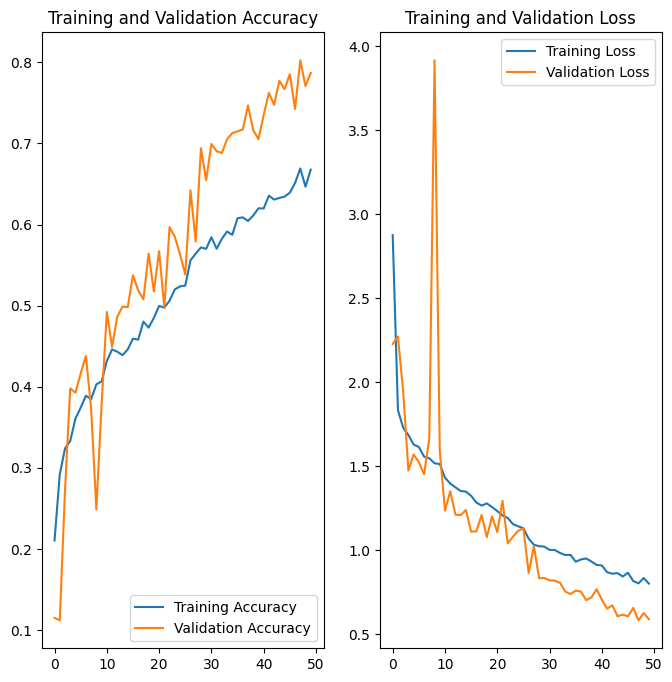

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the validation accuracy improved and the loss has decreased after every epoch

#### Analysis of Results of final model



In [75]:
# Evaluate the model on the training and validation datasets
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)

# Print the final accuracy scores
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Since we got very high accuracy and data augmented by solving class imbalance, 
# In this context, A common heuristic is that if the gap between training and validation accuracy is greater than 10-15%, 
# it is likely overfitting. So, taking an average of 7% as a tolerance
# Check for overfitting or underfitting with a tolerance of 7%
if train_acc > val_acc and (train_acc - val_acc) > 0.07:
    print("The model is likely overfitting.")
elif val_acc > train_acc and (val_acc - train_acc) > 0.07:
    print("The model is likely underfitting.")
else:
    print("The model is performing well with no major overfitting or underfitting.")

169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8687 - loss: 0.4332
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8227 - loss: 0.5564
Final Training Accuracy: 86.96%
Final Validation Accuracy: 80.25%
The model is performing well with no major overfitting or underfitting.


In [82]:
insert_performance("Final Model with Solved Data Imbalance", 86.96, 80.25)


Performance Table:
                                    Model  Training Accuracy  \
0                           Initial Model              54.80   
1            Augmented model with dropout              54.49   
2  Final Model with Solved Data Imbalance              86.96   

   Validation Accuracy  
0                47.97  
1                35.59  
2                80.25  


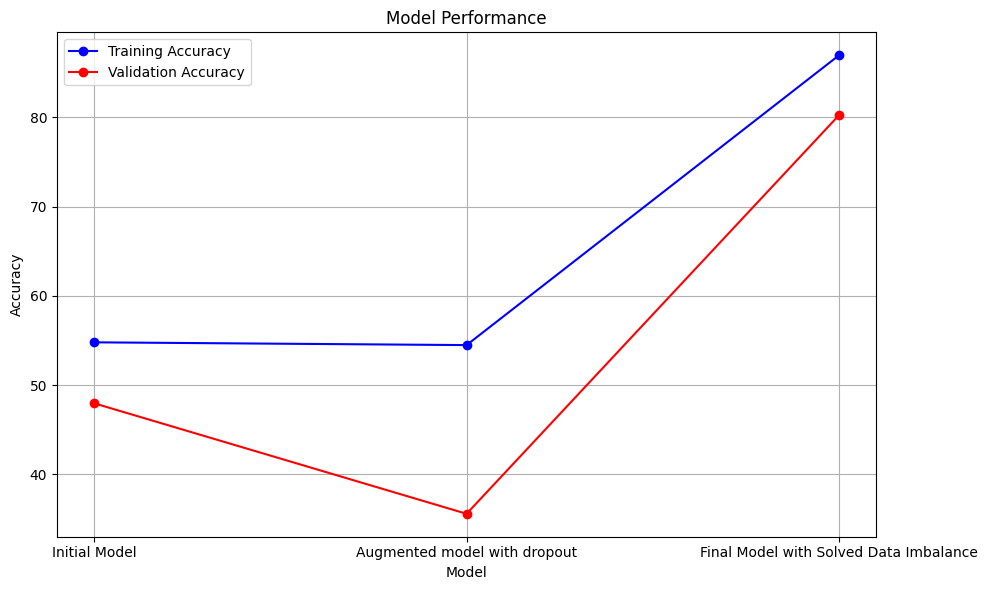

In [84]:
# Display DataFrame as table
print("Performance Table:")
print(accuracy_df)

# Display DataFrame as graph
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df['Model'], accuracy_df['Training Accuracy'], marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(accuracy_df['Model'], accuracy_df['Validation Accuracy'], marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.title('Model Performance')
plt.xlabel('Model')
plt.ylabel('Accuracy')
#plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- We can see that the class rebalance technique has massively improved the model performance and improved both the training and validation accuracy